In [1]:
import os
from pathlib import Path

import yaml
from box import ConfigBox


WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

DATA_ROOT_PATH = "data"


Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


### 1. Prepare base model

In [2]:
import torch
import segmentation_models_pytorch as smp

# Define the U-Net model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained weights
    in_channels=3,                  # Input channels (PNG)
    classes=2,                      # i.e. Output channels, depending on mask_gt
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Print model summary
print(model)

/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### 2. Prepare Dataset

In [3]:
import os
import glob
import cv2
import numpy as np

from torch.utils.data import Dataset, DataLoader

from notebooks.image_processing import normalize_image, get_gt_mask_png

# Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = image_list # This is when image_list is pre-selected for train/val/test split
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    @staticmethod
    def _read_image_png(image_path):
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
        else:
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if image is None:
                print(f"OpenCV could not read: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return image

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx])  # Assuming masks have the same name

        # Read image and mask
        image = self._read_image_png(img_path)
        mask_raw = self._read_image_png(mask_path)

        # Normalize & Convert to tensors
        image = image / 255.0  # when import from preprocessed image dir: /norm_images
        mask = get_gt_mask_png(mask_raw[:,:,0])[:,:,1:] # leave out the 1st channel (empty), [0 1]
        # mask = get_gt_mask_png(mask_raw[:,:,0])[:,:,-1] # test with nuclei channel only
        # mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        # mask = mask / 255.0  # Normalize (Assuming mask values are 0 or 255)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return image, mask
    

################################### EDIT THIS ###################################
# Define dataset and dataloaders
with open("data/metadata/training.txt", "r") as f:
    image_list_train = f.read().splitlines()

train_dataset = SegmentationDataset(
    "data/norm_images",
    "data/masks", # "data/boundary_labels",
    image_list_train,
)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

### 3. Loss functions

In [ ]:
def dice_loss(probs, targets, weights=1., epsilon=1e-6):

    # Flatten tensors
    probs = probs.reshape(-1)
    targets = targets.reshape(-1)
    weights = weights.reshape(-1)

    # Compute Dice score
    intersection = torch.sum(weights * probs * targets)
    denominator = torch.sum(weights * probs) + torch.sum(weights * targets)
    
    dice_score = (2. * intersection + epsilon) / (denominator + epsilon)

    return 1. - dice_score

import torch.nn.functional as F

class WeightedDiceBCELoss(torch.nn.Module):
    def __init__(self, weight_1=4.0, weight_2=333.3, weight_3=1.0, 
                 bce_weight=1.0, epsilon=1e-6):
        """
        Args:
            weight_1: Weight for object foreground in Dice loss.
            weight_2: Weight for boundary foreground in Dice loss.
            weight_3: Weight for boundary channel.
            bce_weight: Weight for binary cross-entropy loss.
            epsilon: Small constant to prevent division by zero.
        """
        super(WeightedDiceBCELoss, self).__init__()
        self.weight_object_foreground = weight_1
        self.weight_boundary_foreground = weight_2
        self.weight_boundary_channel = weight_3
        self.bce_weight = bce_weight
        self.epsilon = epsilon

    def forward(self, logits, targets):
        """
        Args:
            logits: Raw model outputs (before sigmoid), shape (batch_size, 2, H, W)
            targets: Ground truth binary masks (0 or 1), shape (batch_size, 2, H, W)
        """
        # Apply sigmoid activation
        probs = torch.sigmoid(logits)

        # Apply class weights (higher weight for class 1)
        weights_obj = torch.where(targets[:,1,:,:] == 1, self.weight_object_foreground, 1.0)
        weights_bnd = torch.where(targets[:,0,:,:] == 1, self.weight_boundary_foreground, 1.0)

        # Compute Dice loss for each channel
        boundary_channel_dice = dice_loss(
            probs[:,0,:,:], 
            targets[:,0,:,:], 
            weights_bnd, 
            self.epsilon
        )
        object_channel_dice = dice_loss(
            probs[:,1,:,:], 
            targets[:,1,:,:], 
            weights_obj, 
            self.epsilon
        )

        # Compute Binary Crossentropy loss for each channel
        boundary_bce = F.binary_cross_entropy(probs[:,0,:,:], targets[:,0,:,:], weights_bnd)
        object_bce = F.binary_cross_entropy(probs[:,1,:,:], targets[:,1,:,:], weights_obj)

        # Combine losses
        total_loss = (self.weight_boundary_channel * boundary_channel_dice + object_channel_dice) + \
                     self.bce_weight * (self.weight_boundary_channel * boundary_bce + object_bce)
    
        return total_loss


################################### EDIT THIS ###################################
# Loss function
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = WeightedDiceBCELoss(weight_1=4.0, weight_2=333.3, weight_3=2.0, bce_weight=1.0)  # Increase weight for 1s

import torch.optim as optim
# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


### 4. Training

#### 4.1 Helper functions

In [5]:
import torch.nn.functional as F

def pad_images(images, target_height=544, target_width=704):
    height, width = images.shape[-2], images.shape[-1]
    pad_height = target_height - height
    pad_width = target_width - width
    padding = (0, pad_width, 0, pad_height, 0, 0)  # (left, right, top, bottom)
    return F.pad(images, padding, mode='constant', value=0)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(model, dataset, idx=0, save_path=None, if_show=True):
    model.eval()  # Set to evaluation mode
    image, mask = dataset[idx]

    # Pad images to match the target size
    image = pad_images(image)

    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred = model(image).squeeze()
        if len(pred.shape) == 3:
            pred = pred.permute(1, 2, 0).cpu().numpy()
        else:
            pred = pred.cpu().numpy()

    pred = (pred > 0).astype(np.uint8)  # Convert logits to binary mask

    # Plot images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Image")

    mask = mask.squeeze()
    if len(mask.shape) == 3:
        mask = mask.permute(1, 2, 0).cpu().numpy()
    else:
        mask = mask.cpu().numpy()
    if mask.shape[-1] == 2:
        empty_channel = np.zeros_like(mask[:,:,0])
        mask = np.stack([empty_channel, mask[:,:,0], mask[:,:,1]], axis=-1)        
    ax[1].imshow(mask)
    ax[1].set_title("Ground Truth")
    
    if pred.shape[-1] == 2:
        empty_channel = np.zeros_like(pred[:,:,0])
        pred = np.stack([empty_channel, pred[:,:,0], pred[:,:,1]], axis=-1)
    ax[2].imshow(pred * 255)
    ax[2].set_title("Prediction")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    if if_show:
        plt.show()
    else:
        plt.close()

#### 4.2 Training loop

In [7]:
from tqdm import tqdm
import psutil
from datetime import datetime

def train_model(model, train_loader, criterion, optimizer, epochs=10, post_fix=""):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # Pad images to match the target size
            images = pad_images(images)
            masks = pad_images(masks)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
            
            # Get CPU & RAM usage
            ram_used = psutil.virtual_memory().used / 1024**3

            progress_bar.set_postfix(loss=loss.item(), ram_used=f"{ram_used:.2f} GB", cpu_usage=f"{psutil.cpu_percent()}%")

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        visualize_sample(model, train_dataset, idx=2, save_path=f"figures/prediction_epoch_{epoch+1}_{timestamp}_{post_fix}.png", if_show=False)



################################### EDIT THIS ###################################
# Experiment post-fix
EXP_POSTFIX = "weight1_4_weight2_333_weight3_2_bce_1_lr_1e-4"

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10, post_fix=EXP_POSTFIX)

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"models/unet_resnet34_{timestamp}_{EXP_POSTFIX}.pth")  # Save model weights
print("Model saved successfully!")


Epoch 1/10: 100%|██████████| 5/5 [03:29<00:00, 41.86s/it, cpu_usage=83.0%, loss=6.24, ram_used=5.02 GB]


Epoch 1/10, Loss: 6.3221


Epoch 2/10: 100%|██████████| 5/5 [03:27<00:00, 41.42s/it, cpu_usage=81.8%, loss=5.37, ram_used=5.15 GB]


Epoch 2/10, Loss: 5.3186


Epoch 3/10: 100%|██████████| 5/5 [03:28<00:00, 41.71s/it, cpu_usage=84.3%, loss=4.94, ram_used=5.63 GB]


Epoch 3/10, Loss: 5.3625


Epoch 4/10: 100%|██████████| 5/5 [03:30<00:00, 42.07s/it, cpu_usage=80.0%, loss=4.56, ram_used=5.17 GB]


Epoch 4/10, Loss: 4.5438


Epoch 5/10: 100%|██████████| 5/5 [03:28<00:00, 41.69s/it, cpu_usage=82.8%, loss=3.79, ram_used=5.55 GB]


Epoch 5/10, Loss: 4.0762


Epoch 6/10: 100%|██████████| 5/5 [03:25<00:00, 41.17s/it, cpu_usage=83.7%, loss=3.03, ram_used=5.05 GB]


Epoch 6/10, Loss: 3.0914


Epoch 7/10: 100%|██████████| 5/5 [03:28<00:00, 41.70s/it, cpu_usage=86.3%, loss=2.51, ram_used=4.98 GB]


Epoch 7/10, Loss: 2.4785


Epoch 8/10: 100%|██████████| 5/5 [03:29<00:00, 41.92s/it, cpu_usage=87.4%, loss=1.88, ram_used=4.89 GB]


Epoch 8/10, Loss: 2.0509


Epoch 9/10: 100%|██████████| 5/5 [03:29<00:00, 41.90s/it, cpu_usage=86.9%, loss=2.3, ram_used=5.86 GB] 


Epoch 9/10, Loss: 2.0118


Epoch 10/10: 100%|██████████| 5/5 [03:29<00:00, 41.88s/it, cpu_usage=87.8%, loss=1.75, ram_used=5.82 GB]


Epoch 10/10, Loss: 1.8585
Model saved successfully!


### 5. Evaluation (TBC)

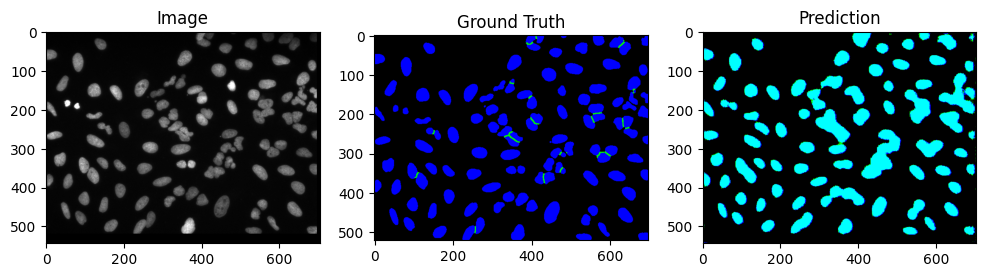

In [8]:
# Visualize prediction
visualize_sample(model, train_dataset, idx=2)